(60, 9)
26    0.588182
35   -0.663523
59    0.325085
28    0.636018
11    1.078499
2     0.843306
34   -1.293362
58   -0.368535
40    0.659936
22    0.097864
4     0.616086
10    1.632598
Name: 入荷量(トン), dtype: float64
    　当月の平均気温(℃)  　一月前の平均気温(℃)  日最高気温の平均(℃)  日最低気温の平均(℃)  降水量の合計(mm)  \
26    -1.059432     -1.264645    -1.024412    -1.087541   -0.453553   
35    -1.315041     -0.595166    -1.341953    -1.280215   -1.056864   
59    -1.059432     -0.434492    -1.134861    -0.959091   -0.530571   
28     0.487675     -0.220258     0.590901     0.428166   -0.765905   
11    -0.951807     -0.327375    -1.024412    -0.882021   -0.479226   
2     -0.817276     -1.425320    -0.734484    -0.882021   -0.380813   
34    -0.602026      0.060923    -0.582617    -0.612277   -0.783020   
58    -0.440589      0.409051    -0.430750    -0.432447    0.154037   
40     0.460769      0.087702     0.521871     0.351096    0.231055   
22    -0.669292      0.315324    -0.734484    -0.586587    0.004279   
4

UnicodeDecodeError: 'utf-8' codec can't decode byte 0x93 in position 0: invalid start byte

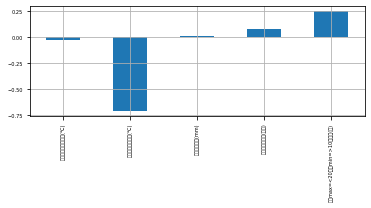

In [120]:
# -*- coding: utf-8 -*-
from sklearn.linear_model import Lasso,LassoCV,ElasticNet,ElasticNetCV
from sklearn.preprocessing import StandardScaler
import glob
import pandas as pd
import numpy as np
import copy
from sklearn.model_selection import KFold, train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import os
import json
import warnings
warnings.filterwarnings('ignore')
##############################
#lassoで機械的に変数を削除して、上位の変数を残す変数に追加してもう一度lassoをかける
##############################

class std_class():
    def __init__(self, data):
        self.data = data 
    #データ標準化
    def std(self):
        data = self.data
        scaler = StandardScaler()
        scaler.fit(data.ix[:,1:])
        scaler.transform(data.ix[:,1:])
        data_std = pd.DataFrame(scaler.transform(data.ix[:,1:]), columns=data.ix[:,1:].columns)
        data_std = pd.concat([data.ix[:,0], data_std],axis=1)
        return data_std


def predict(model, data_path = "data/" ,file_name = "tokyo_2019.csv"):
    data = pd.read_csv(data_path+file_name)
    #classを読み込む
    std_instance = std_class(data)
    data_std = std_instance.std()
    data_std = data
    pred = model.predict(data_std.ix[:,1:])
    pred = pd.DataFrame(pred)
    error = abs((data_std.ix[:,0] - pred.T) / data_std.ix[:,0])
    output = pd.concat([data_std.ix[:,0],pred,error.T], axis=1)
    output.to_csv("./output/predict.csv")
    print(error.T.mean())

'''
lassoで分析して、グラフの表示
'''

def main(data_path = "data/" ,file_name = "tokyo.csv"):
    data = pd.read_csv(data_path+file_name)
    print(data.shape)
#     #標準化
#     sc = StandardScaler()
#     data = sc.fit(data)
    #インスタンス生成
    std_instance = std_class(data)
    data_std = std_instance.std()
    #サンプリング
    X_train, X_test, Y_train, Y_test = train_test_split(data_std.ix[:,2:],data_std.ix[:,1], train_size=0.8,random_state=0)
    print(Y_test)
    print(X_test)
    test_data = pd.concat([Y_test, X_test],axis = 1)
#     test_data.to_csv("data/tokyo_2019.csv", index=False)
    #モデリング
    model = Lasso(alpha=0.005,normalize=False,random_state=0)
    model.fit(X_train , Y_train)
    #model = LogisticRegression(penalty ='l1')
    #model.fit(data_std.ix[:,1:] ,data_std.ix[:,0])
    #pandasでグラフ化のため、DF化
    coef = pd.DataFrame(model.coef_)
    coef.index = X_train.columns
    coef.to_csv("./output/coef.csv")
    coef = coef[coef[0] != 0]
    #棒グラフで凡例消すグリッド
    coef.plot(grid=True, kind='bar', legend=False, fontsize=5)
    #軸ラベルつける
    #plt.xticks(list(range(int(pd.DataFrame(X_train.ix[:,1:].columns).count()))),list(X_train.ix[:,1:].columns))
    #plt.xticks([0,1,2,3,4,5,6,7,8,9,10],list(data_std.ix[:,1:].columns))
    plt.subplots_adjust(bottom=0.5)
    plt.savefig(data_path+'../output/graph.png')
    predict(model = model)

if __name__ == '__main__':
    main()

